In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression

In [2]:
y_path = {
    'test': 'data/paws/test.tsv',
    'train': 'data/paws/train.tsv',
    'dev': 'data/paws/dev.tsv'
}

X_path = {
    'test': 'data/features/test.csv',
    'train': 'data/features/train.csv',
    'dev': 'data/features/dev.csv'
}

# { Feature_name: column_name }
features = {
    'Cosine dist': 'bert_cosine_distance',
    '3-grams Jaccard': '3_grams_jaccard',
    '2-grams Jaccard': '2_grams_jaccard',
    '4-grams Jaccard': '4_grams_jaccard',
    'RoBERTa predictions raw': 'predictions_raw',
    'RoBERTa predictions binary': 'predictions',
    'WordNet shortest path': 'shortest_path_distance',
    'WordNet Wu and Palmer': 'wup_similarity',
    'Word Mover\'s Distance': 'wm_distance',
}

### Read data

In [3]:
y_train = pd.read_csv(y_path['train'], sep='\t',
                     usecols=['label'])['label'].values
y_test = pd.read_csv(y_path['test'], sep='\t',
                    usecols=['label'])['label'].values
y_dev = pd.read_csv(y_path['dev'], sep='\t',
                    usecols=['label'])['label'].values

X_test = pd.read_csv(X_path['test'])
X_train = pd.read_csv(X_path['train'])
X_dev = pd.read_csv(X_path['dev'])

X_dev.head()

,bert_cosine_distance,prediction_seamese_bert,3_grams_jaccard,2_grams_jaccard,4_grams_jaccard,predictions_raw,predictions,shortest_path_distance,wup_similarity,wm_distance
0,0.971162,0.917569,0.137931,0.320000,0.064516,0.001696,0,0.972221,0.979166,0.121480
1,0.968465,0.398436,0.117647,0.461538,0.055556,0.986788,1,0.999998,0.999998,0.000000
2,0.965077,0.943639,0.354839,0.517241,0.290323,0.208429,0,0.925925,0.965277,0.071862
3,0.958467,0.774849,0.631579,0.736842,0.526316,0.995167,1,0.830092,0.856937,0.160852
4,0.982486,0.645754,0.666667,0.777778,0.555556,0.994273,1,0.933332,0.946969,0.121676


In [4]:
y_train

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

### Model Class

In [5]:
class ModelLR:
    def __init__(self, columns):
        self.columns = columns

        self.X_test = (X_test[columns]
                       .copy()
                       .replace(np.inf, 10))
        self.X_train = (X_train[columns]
                        .copy()
                        .replace(np.inf, 10))
        self.X_dev = (X_dev[columns]
                      .copy()
                      .replace(np.inf, 10))

        self.model = LogisticRegression(max_iter=1000)
        self.model.fit(self.X_train, y_train)

        self.y_predictions_test = self.model.predict(self.X_test)
        self.y_predictions_dev = self.model.predict(self.X_dev)

        self.y_proba_test = self.model.predict_proba(self.X_test)[:, 1]
        self.y_proba_dev = self.model.predict_proba(self.X_dev)[:, 1]

        print("Accuracy on test set:",
              accuracy_score(y_test, self.y_predictions_test))
        print("Accuracy on validation set:", accuracy_score(y_dev, self.y_predictions_dev))

        self.feature_importance = self.model.coef_[0]



### Functions

In [7]:
def roc_auc(y, y_probabilities):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    fpr, tpr, thr_roc = roc_curve(y, y_probabilities)
    auc_roc = auc(fpr, tpr)

    precision, recall, thr_pr = precision_recall_curve(y, y_probabilities)
    auc_pr = auc(recall, precision)

    ax1.plot(fpr, tpr,
             label=f'AUC = {auc_roc*100:.2f}%',
             linewidth=3)

    ax2.plot(recall, precision,
             label=f'AUC = {auc_pr*100:.2f}%',
             linewidth=2, color='darkblue')


    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC-curve')
    ax1.legend()
    ax1.grid(visible=True)

    ax2.legend()
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Recall-Precision curve')
    ax2.grid(visible=True)

    plt.show()

In [9]:
def feature_importance(importance, names):

    plt.figure(figsize=(8,6))
    # plot feature importance
    ax = sns.barplot(x=importance, y=names,palette='rocket', orient='h')
    ax.bar_label(ax.containers[0], fmt='  %.2f  ')
    ax.set_xlim(right=14, left=-5)
    plt.show()


In [11]:
def confusion(y_true, y_pred):
    cf_matrix = confusion_matrix(y_true, y_pred)

    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = [f'{value:d}' for value in cf_matrix.flatten()]
    group_percentages = [f'{value:.2%}' for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f'{v1}\n\n{v2}\n\n{v3}' for v1, v2, v3 in zip(group_names,group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='rocket')

# Model with all features

In [14]:
all_columns_model = ModelLR([*features.values()])

Accuracy on test set: 0.925
Accuracy on validation set: 0.937375


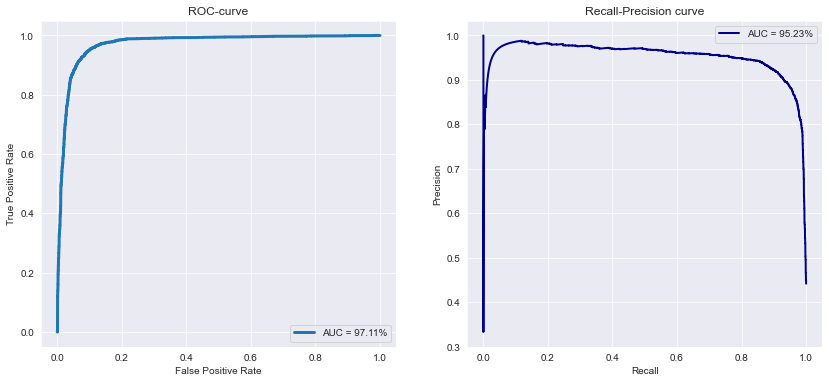

In [15]:
roc_auc(y_test, all_columns_model.y_proba_test)

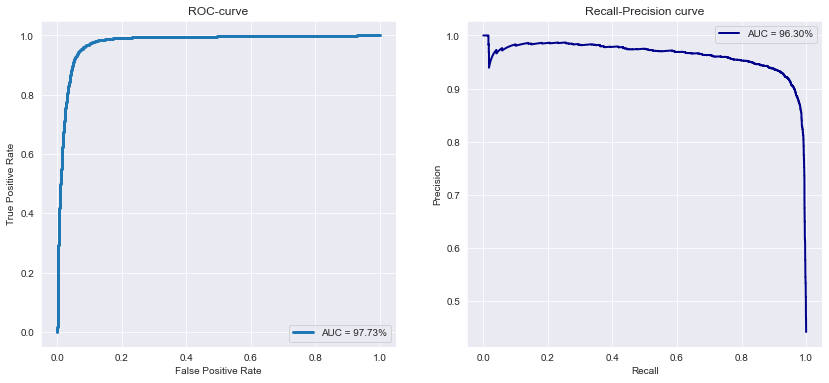

In [30]:
roc_auc(y_dev, all_columns_model.y_proba_dev)

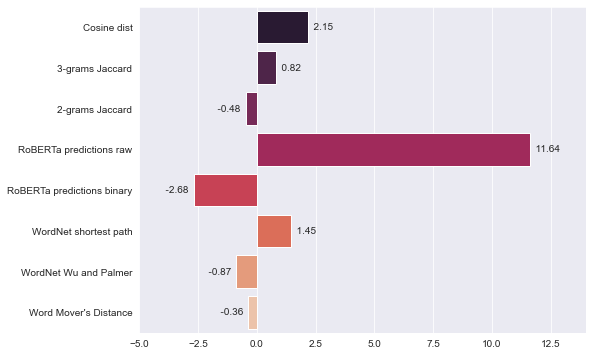

In [16]:
feature_importance(all_columns_model.feature_importance,
                   [*features.keys()])

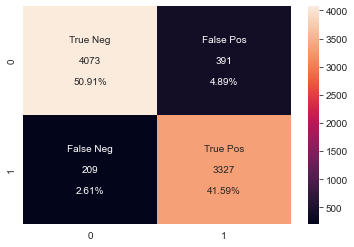

In [17]:
confusion(y_test, all_columns_model.y_predictions_test)

In [18]:
print(classification_report(y_test, all_columns_model.y_predictions_test))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      4464
           1       0.89      0.94      0.92      3536

    accuracy                           0.93      8000
   macro avg       0.92      0.93      0.92      8000
weighted avg       0.93      0.93      0.93      8000



# Model without Roberta's predictions

In [19]:
features = {
    'Cosine dist': 'bert_cosine_distance',
    '3-grams Jaccard': '3_grams_jaccard',
    '2-grams Jaccard': '2_grams_jaccard',
    '4-grams Jaccard': '4_grams_jaccard',
    # 'RoBERTa predictions raw': 'predictions_raw',
    # 'RoBERTa predictions binary': 'predictions',
    'WordNet shortest path': 'shortest_path_distance',
    'WordNet Wu and Palmer': 'wup_similarity',
    'Word Mover\'s Distance': 'wm_distance',
}

In [20]:
no_roberta = ModelLR([*features.values()])

Accuracy on test set: 0.7115
Accuracy on validation set: 0.731375


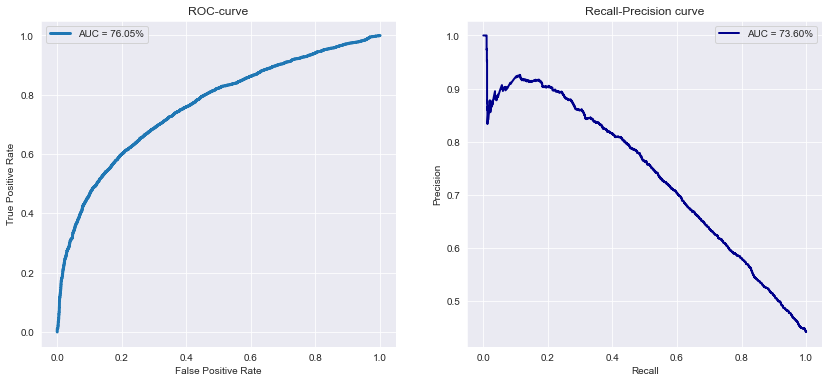

In [21]:
roc_auc(y_test, no_roberta.y_proba_test)

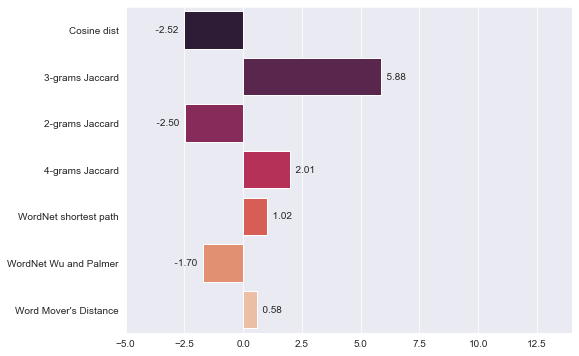

In [22]:
feature_importance(no_roberta.feature_importance,
                   [*features.keys()])

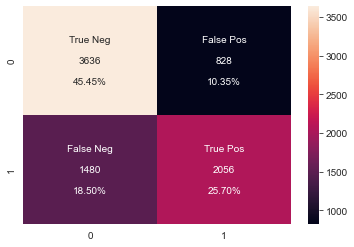

In [23]:
confusion(y_test, no_roberta.y_predictions_test)

In [24]:
print(classification_report(y_test, no_roberta.y_predictions_test))

              precision    recall  f1-score   support

           0       0.71      0.81      0.76      4464
           1       0.71      0.58      0.64      3536

    accuracy                           0.71      8000
   macro avg       0.71      0.70      0.70      8000
weighted avg       0.71      0.71      0.71      8000



# Only Roberta's predictions

In [26]:
print("Accuracy on test set:",
      accuracy_score(y_test, X_test['predictions']))
print("Accuracy on validation set:", accuracy_score(y_dev, X_dev['predictions']))

Accuracy on test set: 0.919625
Accuracy on validation set: 0.931375


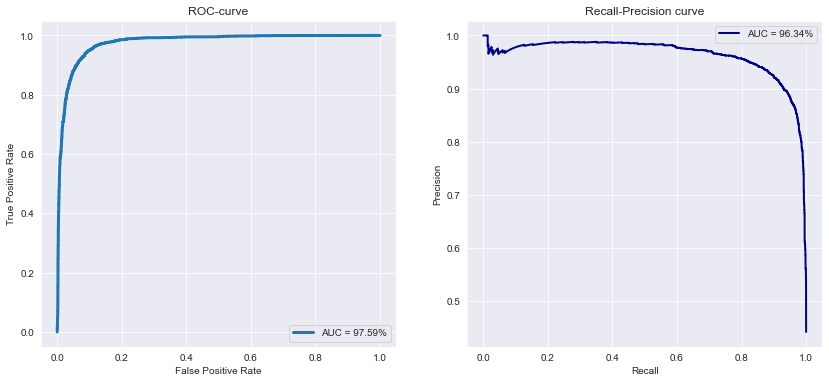

In [27]:
roc_auc(y_test, X_test['predictions_raw'])

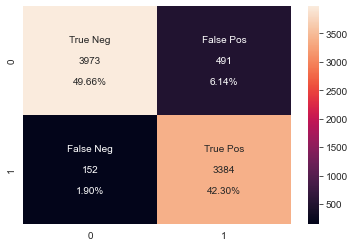

In [28]:
confusion(y_test, X_test['predictions'])

In [29]:
print(classification_report(y_test, X_test['predictions']))

              precision    recall  f1-score   support

           0       0.96      0.89      0.93      4464
           1       0.87      0.96      0.91      3536

    accuracy                           0.92      8000
   macro avg       0.92      0.92      0.92      8000
weighted avg       0.92      0.92      0.92      8000

